In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.h3_utils import get_resolution_buffered_suffix
from src.tools.osmnx_utils import generate_data_for_place, get_place_dir_name
from src.tools.feature_extraction import generate_features_for_edges
from pathlib import Path

Speedups enabled: True


In [4]:

place_dir = Path(GENERATED_DATA_DIR) / get_place_dir_name("Wrocław,Poland")
network_type = "drive"
resolution = 9
buffered = False


edges_path = place_dir/ f"edges_{network_type}_{get_resolution_buffered_suffix(resolution, buffered)}.feather"
edges: gpd.GeoDataFrame = gpd.read_feather(edges_path)  # type: ignore
edges

,u,v,key,id,h3_id,geometry,oneway_0,oneway_1,lanes_1,lanes_2,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
0,95584835,297779709,0,0,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04947 51.083...",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,95584835,241778108,0,1,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04933 51.083...",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,95584835,95584852,0,2,891e2040b03ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,95584835,95584852,0,2,891e2040b07ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,95584835,3019848617,0,3,891e2040b03ffff,"LINESTRING (17.04960 51.08289, 17.04957 51.082...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,9217153042,9217153043,0,9727,891e20474afffff,"LINESTRING (17.09524 51.15730, 17.09528 51.15734)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13512,9217153042,9217153043,1,9728,891e20474afffff,"LINESTRING (17.09524 51.15730, 17.09528 51.15734)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13513,9217153045,9217153046,0,9729,891e2047437ffff,"LINESTRING (17.09581 51.15703, 17.09586 51.15707)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13514,9217153047,9217153048,0,9730,891e2047437ffff,"LINESTRING (17.09647 51.15701, 17.09649 51.15706)",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for col in edges_shp:
    print(col, edges_shp[col].unique())
edges_shp.columns

id [   0    1    2 ... 9680 9681 9682]
u [  95584835   95584841   95584850 ... 8150476313 8570024805 8586747002]
v [ 297779709  241778108   95584852 ... 7528669647 8570024807 8586747003]
key [0 1 2 3]
osmid ['[24707867, 656793686]' '[656794402, 28458110]'
 '[301726798, 189513998, 301726791]' ... '875668659'
 '[923192968, 923192971]' '925229680']
oneway [1 0]
lanes ['2' "['3', '4', '2']" '3' None "['3', '2']" '4' "['2', '5']" '1'
 "['4', '2']" "['3', '4']" "['3', '4', '5']" '5' "['3', '2', '1']"
 "['2', '1']" "['3', '5']" '6' "['6', '4']" "['4', '5']" "['3', '1']"
 "['3', '2', '5']" "['4', '2', '1']" "['4', '1']" "['4', '2', '5']"
 "['6', '5']" '7']
name ['Bardzka' 'Aleja Armii Krajowej' 'Biskupa Bernarda Bogedaina' ...
 'Kurlandzka' 'Korzenna' 'Frezjowa']
highway ['tertiary' 'primary' 'secondary' 'unclassified' 'residential'
 'living_street' "['residential', 'unclassified']" 'secondary_link'
 'tertiary_link' 'primary_link' "['residential', 'living_street']"
 "['unclassified', 'tertiary

Index(['id', 'u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'name', 'highway',
       'maxspeed', 'length', 'from', 'to', 'ref', 'bridge', 'access',
       'junction', 'width', 'tunnel', 'h3_id', 'geometry'],
      dtype='object')

In [14]:
from src.tools.feature_extraction import convert_to_list

maxspeeds = ['50','30',None,'60',"['80','60']",'80',"['80','100']","['80','50']"
,'100',"['80','50','60']","['30','50']",'40',"['50','70']"
,"['50','60']",'10',"['30','50','70']","['80','40']","['60','40']"
,"['50','40']",'20',"['30','10']","['50','10']",'7','5'
,"['50','60','40']","['20','30']",'70',"['60','70']"
,"['70','50','60']","['30','7']",'DE:urban',"['30','60']"
,"['30','15']","['30','50','60']","['60','50','70']"
,"['30','50','10']","['20','10']",'15']

widths = [None,'12','5','6','8','9','13',"['7','5.5','6.5']"
,"['5.5','7','6.5']",'7','24',"['3','5']",'4.6','3','10.5','14','10'
,'4',"['5','7']","['5','6']",'15','6.5',"['7','6.5']",'5.5'
,"['3','6']",'3.2','7.8',"['4.6','3.5']",'4.5',"['4.5','6.5']",'5.7'
,'12.4','4.7',"['8','6']",'2','12.45','4 m','7.5','11','2.7','4.8','6.2'
,"['3','6','5']",'3.5','11.5','8.5',"['9.4','7','6.5']",'6.7','5.6'
,'6.3',"['5','3']",'25','3.6',"['11','10.5']","['7','6']"
,"['3','3.3']","['5.5','6']",'9.5']

highways = ['tertiary','secondary','residential','primary','motorway_link','motorway'
,"['motorway','motorway_link']","['secondary','motorway_link']"
,'unclassified',"['residential','unclassified']",'secondary_link'
,'primary_link','trunk_link',"['motorway','primary']",'living_street'
,"['living_street','residential']","['motorway','secondary']"
,"['secondary','residential']",'trunk',"['primary','trunk']"
,"['residential','tertiary']",'tertiary_link'
,"['primary_link','motorway_link']"
,"['motorway','primary_link','motorway_link']"
,"['motorway_link','secondary_link']","['secondary','tertiary']"
,"['primary','primary_link']","['living_street','unclassified']"
,"['tertiary_link','tertiary']","['unclassified','tertiary']"
,"['residential','secondary_link']","['secondary','secondary_link']"]

for maxspeed in maxspeeds:
    convert_to_list(maxspeed, "maxspeed")

for width in widths:
    convert_to_list(width, "width")

for highway in highways:
    convert_to_list(highway, "highway")

In [15]:
from typing import Union, List, Dict
import itertools
from src.tools.feature_extraction import explode_and_pivot, convert_to_list, FEATURESET

def generate_features_for_edges(edges: Union[pd.DataFrame, gpd.GeoDataFrame], featureset: Dict[str, List[str]]) -> gpd.GeoDataFrame:
    for feature in featureset.keys():
        # if feature == "width": continue
        print(feature)
        if feature in edges:
            edges = edges.join(explode_and_pivot(edges, feature))
    
    feature_column_names = list(itertools.chain(*[[f"{k}_{v}" for v in vs] for k, vs in featureset.items()]))
    columns_to_keep = ["id", "h3_id", "geometry"] + feature_column_names
    columns_to_drop = list(set(edges.columns) - set(columns_to_keep))
    columns_to_add = list(set(columns_to_keep) - (set(columns_to_keep).intersection(set(edges.columns))))

    edges.drop(columns=columns_to_drop, inplace=True)

    for c in columns_to_add:
        edges[c] = 0
    
    edges = edges.reindex(columns_to_keep, axis=1)
    return gpd.GeoDataFrame(edges)  # type: ignore

df = generate_features_for_edges(edges_shp, FEATURESET)
df


oneway
lanes
highway
maxspeed
bridge
access
junction
width
tunnel


,id,h3_id,geometry,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
0,0,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04947 51.083...",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04933 51.083...",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,891e2040b07ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,891e2040b03ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,891e2040b03ffff,"LINESTRING (17.04960 51.08289, 17.04957 51.082...",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14667,9678,891e2040c67ffff,"LINESTRING (17.01744 51.11012, 17.01741 51.110...",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14668,9679,891e2040c67ffff,"LINESTRING (17.01783 51.11021, 17.01775 51.110...",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14669,9680,891e204e093ffff,"LINESTRING (17.04155 51.05842, 17.04163 51.058...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14670,9681,891e20462c3ffff,"LINESTRING (17.13918 51.16063, 17.13949 51.160...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

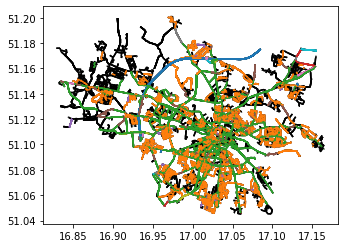

In [16]:
ax = edges_shp.plot(color="black")
edges_shp.plot(column="maxspeed", ax=ax)

In [17]:
df

,id,h3_id,geometry,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
0,0,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04947 51.083...",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,891e2040b03ffff,"LINESTRING (17.04951 51.08311, 17.04933 51.083...",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,891e2040b07ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,891e2040b03ffff,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,891e2040b03ffff,"LINESTRING (17.04960 51.08289, 17.04957 51.082...",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14667,9678,891e2040c67ffff,"LINESTRING (17.01744 51.11012, 17.01741 51.110...",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14668,9679,891e2040c67ffff,"LINESTRING (17.01783 51.11021, 17.01775 51.110...",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14669,9680,891e204e093ffff,"LINESTRING (17.04155 51.05842, 17.04163 51.058...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14670,9681,891e20462c3ffff,"LINESTRING (17.13918 51.16063, 17.13949 51.160...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

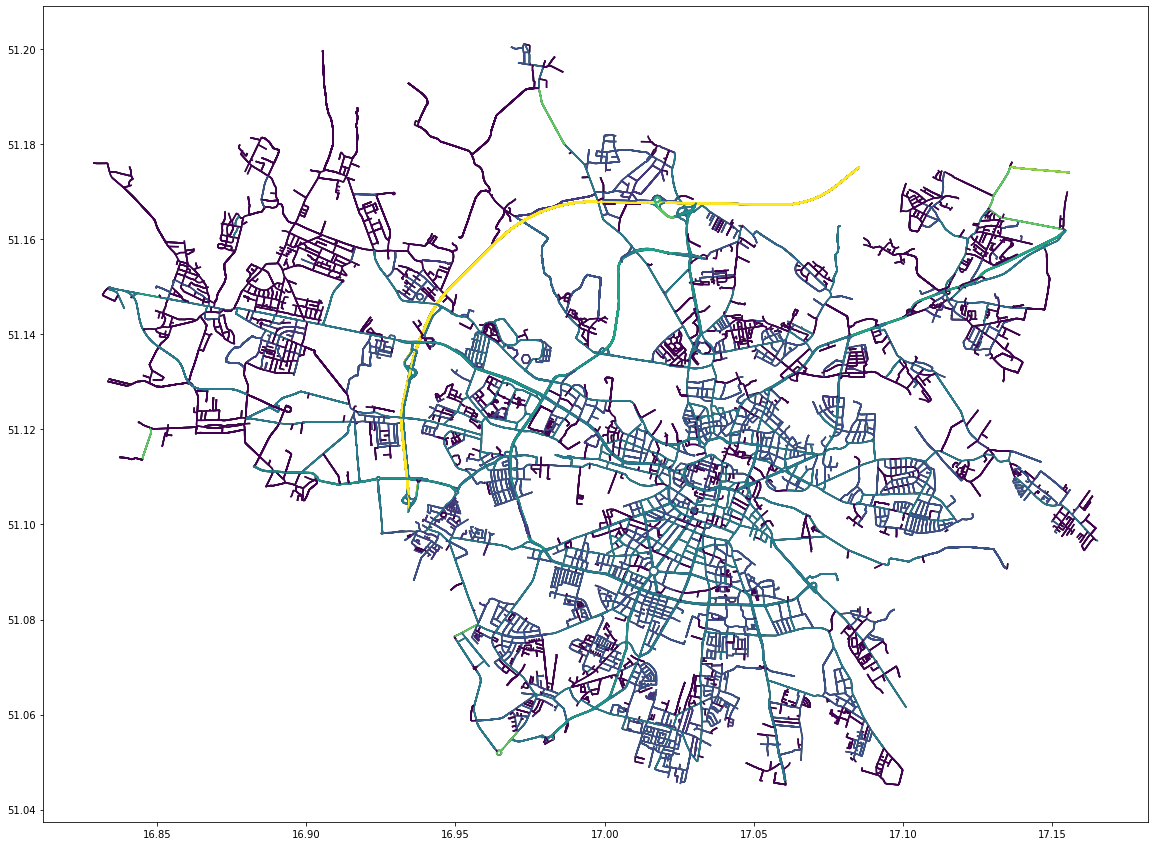

In [18]:
from src.tools.feature_extraction import melt_and_max
column_name = "maxspeed"

columns = [x for x in df.columns if column_name in x]

ble = df.join(melt_and_max(df, column_name, columns), on="id")

fig, ax = plt.subplots(figsize=(20, 15))
edges_shp.plot(color="black", ax=ax)
ble.plot(ax=ax, column=column_name)